# Comparative Analysis script of RTStruct Segmentations for Radiophysical Assessment

## Objective:
This notebook is dedicated to the systematic analysis of segmentation results, comparing machine-generated RTStruct files against reference RTStructs created manually by medical professionals. The goal is to quantify the similarity and precision of automated segmentations relative to the gold standard of human expertise, specifically within the context of radiophysics.

**Methodology**:
I use a comprehensive suite of spatial, statistical, and intensity metrics to assess segmentation accuracy and similarity:

- **Spatial Overlap and Distance Metrics**:
  - **Dice Similarity Coefficient (DSC)**: Measures the overlap between two volumes, providing a statistical validation of segmentation precision.
  - **Jaccard Index**: Quantifies the similarity and diversity between sample sets, indicating the proportionate size of the intersection divided by the union of the sample sets.
  - **Mean Surface Distance (MSD)**: Calculates the average Euclidean distance between the surfaces of two volumes, offering insights into the contour accuracy.
  - **Volume Overlap Error (VOE)**: Represents the proportion of the total volume that is over-segmented or under-segmented relative to the reference, complementing the Dice coefficient by providing error rates.
  - **Hausdorff Distance (95th percentile)**: Measures the distance between the surface points of the segmented volumes, excluding the top 5% of the largest errors. This metric provides a more robust evaluation of the segmentation quality by focusing on the majority of points and reducing the influence of outliers, giving a more accurate representation of the model’s overall performance.
  - **Variation of Information (VI)**: Measures the amount of information lost and gained in the segmentation process, reflecting the complexity and precision of the information captured by the segmentation.
  - **Cosine Similarity**: Assesses the cosine angle between the multidimensional representations of the segmented volumes, useful for understanding the orientation and agreement in the segmented shapes.

- **Statistical Analysis of Volumes, Diameters, and Intensity Distributions**:
  - The volumes and maximum diameters of segmented ROIs (Regions of Interest) are extracted and statistically analyzed. Descriptive statistics (mean, median, standard deviation, minimum, maximum, and quartiles) are calculated to provide a comprehensive overview of the data distribution and central tendencies.
  - **Intensity Distribution Analysis**: For each ROI, the minimum, maximum, mean, and standard deviation of intensities are computed, along with higher-order statistical measures such as **skewness** and **kurtosis**. This provides insight into the distribution of pixel intensities within the segmented regions, highlighting asymmetry (skewness) and the presence of outliers or heavy tails (kurtosis).

**Data Handling**:
- The segmentation results, including both reference and generated RTStructs, are first converted from DICOM format into voxel arrays for computational analysis.

# Imports

In [1]:
import numpy as np
import os
from scipy.spatial.distance import cdist, directed_hausdorff
from sklearn.metrics import mutual_info_score
from dicompylercore import dicomparser
from sklearn.metrics.pairwise import cosine_similarity
from shapely.geometry import Polygon
import pandas as pd
from scipy.ndimage import distance_transform_edt, binary_fill_holes
import pydicom
from scipy.stats import kurtosis, skew
from skimage.draw import line
import matplotlib.pyplot as plt


In [ ]:
!pip3 install -r requirements.txt

# Configuration :

In [2]:
dicom_folder_path = 'IRM' # folder containing MR images
dicom_reference_rtstruct_path = 'official.dcm' # reference META RTSTRUCT file
dicom_generated_rtstruct_path = 'fromMetIA.dcm' # generated META RTSTRUCT file
#dicom_generated_rtstruct_path = 'rtss2.dcm'
rois_to_ignore_original = [] # rois qu'on ne veut pas analyser dans le rtstruct de référence (pour la similarité only)
rois_to_ignore_generated = [] # rois qu'on ne veut pas analyser dans le rtstruct généré (pour la similarité only)

# Launch this script 

In [3]:
######################################################################################################################################@
################################################################# Metrics ########################################################## 
######################################################################################################################################@
def dice_coefficient(volume1, volume2):
    """
    Calcul de l'indice de Dice entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Indice de Dice.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    
    if size1 + size2 == 0:
        return 1.0  # si les deux volumes sont vides bas logiquement le dice est de 1
    return (2. * intersection) / (size1 + size2)

def mean_surface_distance(volume1, volume2):
    """
    Calcul de la distance moyenne des surfaces entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Distance moyenne des surfaces.
    """
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    
    if len(points1) == 0 or len(points2) == 0:
        return np.inf  # si l'un des volumes est vide, retourne infini
    
    d1 = cdist(points1, points2, metric='euclidean')
    d2 = cdist(points2, points1, metric='euclidean')
    
    msd1 = np.mean(np.min(d1, axis=1))
    msd2 = np.mean(np.min(d2, axis=1))
    
    return (msd1 + msd2) / 2

def volume_overlap_error(volume1, volume2):
    """
    Calcul de l'erreur de chevauchement entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Erreur de chevauchement.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    union = np.sum((volume1 > 0) | (volume2 > 0))
    
    if union == 0:
        return 0.0  # si l'union est vide, aucune erreur
    
    return 1 - (intersection / union)

def hausdorff_distance_95(volume1, volume2):
    """
    Calcul de la distance de Hausdorff au 95e percentile entre deux volumes binaires. (exclusion des outliers 5%)
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Distance de Hausdorff au 95e percentile.
    """
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    
    if len(points1) == 0 or len(points2) == 0:
        return np.inf  # si l'un des volumes est vide, retourne infini
    
    # calculer toutes les distances entre les points de surface des deux volumes
    distances1_to_2 = cdist(points1, points2)
    distances2_to_1 = cdist(points2, points1)
    
    # calculer le 95e percentile des distances
    hd_95_1_to_2 = np.percentile(np.min(distances1_to_2, axis=1), 95)
    hd_95_2_to_1 = np.percentile(np.min(distances2_to_1, axis=1), 95)
    
    return max(hd_95_1_to_2, hd_95_2_to_1)

def jaccard_index(volume1, volume2):
    """
    Calcul de l'indice de Jaccard entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Indice de Jaccard.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    union = np.sum((volume1 > 0) | (volume2 > 0))
    
    if union == 0:
        return 1.0  # si les deux volumes sont vides, l'indice de Jaccard est maximal
    
    return intersection / union

def tanimoto_coefficient(volume1, volume2):
    """
    Calcul du coefficient de Tanimoto entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Coefficient de Tanimoto.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    
    if size1 + size2 - intersection == 0:
        return 1.0  # si les deux volumes sont vides ou identiques
    
    return intersection / (size1 + size2 - intersection)

def variation_of_information(volume1, volume2):
    """
    Calcul de la variation de l'information entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Variation de l'information.
    """
    volume1_flat = volume1.flatten()
    volume2_flat = volume2.flatten()
    
    h1 = mutual_info_score(volume1_flat, volume1_flat)
    h2 = mutual_info_score(volume2_flat, volume2_flat)
    mi = mutual_info_score(volume1_flat, volume2_flat)
    
    return h1 + h2 - 2 * mi

def cosine_similarity_3d(volume1, volume2):
    """
    Calcul de la similarité cosinus entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Similarité cosinus.
    """
    volume1_flat = volume1.flatten().reshape(1, -1)
    volume2_flat = volume2.flatten().reshape(1, -1)
    
    return cosine_similarity(volume1_flat, volume2_flat)[0][0]




def similarity_metrics(volume1, volume2):
    dsc = dice_coefficient(volume1, volume2)
    msd = mean_surface_distance(volume1, volume2)
    voe = volume_overlap_error(volume1, volume2)
    hd = hausdorff_distance_95(volume1, volume2)
    ji = jaccard_index(volume1, volume2) 
    tc = tanimoto_coefficient(volume1, volume2)
    vi = variation_of_information(volume1, volume2)
    cs = cosine_similarity_3d(volume1, volume2)
    
    return {
        'Dice Similarity Coefficient': dsc,
        'Mean Surface Distance': msd,
        'Volume Overlap Error': voe,
        'Hausdorff Distance': hd,
        'Jaccard Index': ji,
        'Tanimoto Coefficient': tc,
        'Variation of Information': vi,
        'Cosine Similarity': cs
    }

######################################################################################################################################@
################################################################# Load data ########################################################## 
######################################################################################################################################@
def load_dicom_files(directory):
    """
    Charge tous les fichiers DICOM d'un répertoire.
    
    Args:
        directory (str): Le chemin du répertoire contenant les fichiers DICOM.
        
    Returns:
        list: Une liste d'objets pydicom représentant les fichiers DICOM.
    """
    dicom_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.dcm'):
                filepath = os.path.join(root, file)
                dicom_files.append(pydicom.dcmread(filepath))
    dicom_files.sort(key=lambda x: int(x.InstanceNumber)) # ESSENTIEL pour l'ordre des slices
    return dicom_files

def read_dicom_rtstruct(filepath, rois_to_ignore=None, is_original=True):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    
    # verif que le fichier est un RT Structure Set
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour, structure in zip(contour_data, structures):
        roi_name = structure.ROIName

        # ignorer les ROIs dont le nom est dans la liste rois_to_ignore
        if roi_name in rois_to_ignore:
            print(f"ROI {roi_name} ignorée.")
            continue 
        
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours

def convert_contours_to_voxel_space(contours, dicom_files):
    """
    Convertit les coordonnées des contours en coordonnées de voxels.
    
    Args:
        contours (list): Liste des contours.
        dicom_files (list): Liste des fichiers DICOM.
        
    Returns:
        list: Liste des contours convertis en coordonnées de voxels.
    """
    pixel_spacing = dicom_files[0].PixelSpacing
    slice_thickness = dicom_files[0].SliceThickness
    image_position_patient = dicom_files[0].ImagePositionPatient

    contours_voxel_space = []

    for contour in contours:
        voxel_contour = []
        for point in contour:
            x_mm, y_mm, z_mm = point
            x_voxel = int((x_mm - image_position_patient[0]) / pixel_spacing[0])
            y_voxel = int((y_mm - image_position_patient[1]) / pixel_spacing[1])
            z_voxel = int((z_mm - image_position_patient[2]) / slice_thickness)
            voxel_contour.append((x_voxel, y_voxel, z_voxel))
        contours_voxel_space.append(np.array(voxel_contour))
    
    return contours_voxel_space



######################################################################################################################################@
# New : Les fonctions que j'ai déjà implémenté mais en version dictionnaire pour faciliter la manipulation des données 

def read_dicom_rtstruct_dict(filepath):
    ds = pydicom.dcmread(filepath)
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    contours = {}
    for i, roi_contour in enumerate(ds.ROIContourSequence):
        contour_points = []
        for contour_sequence in roi_contour.ContourSequence:
            points = contour_sequence.ContourData
            num_points = len(points) // 3
            points = np.array(points).reshape(num_points, 3)
            contour_points.append(points)
        contours[f'ROI_{i+1}'] = contour_points
    
    return contours

def convert_contours_to_voxel_space_dict(contours, dicom_files):
    pixel_spacing = dicom_files[0].PixelSpacing
    slice_thickness = dicom_files[0].SliceThickness
    image_position_patient = dicom_files[0].ImagePositionPatient

    contours_voxel_space = {}
    for roi_name, contour_list in contours.items():
        voxel_contour_list = []
        for contour in contour_list:
            voxel_contour = []
            for point in contour:
                x_mm, y_mm, z_mm = point
                x_voxel = int((x_mm - image_position_patient[0]) / pixel_spacing[0])
                y_voxel = int((y_mm - image_position_patient[1]) / pixel_spacing[1])
                z_voxel = int((z_mm - image_position_patient[2]) / slice_thickness)
                voxel_contour.append((x_voxel, y_voxel, z_voxel))
            voxel_contour_list.append(np.array(voxel_contour))
        contours_voxel_space[roi_name] = voxel_contour_list
    
    return contours_voxel_space

######################################################################################################################################@

import numpy as np
from scipy.ndimage import binary_fill_holes
from skimage.draw import line

def remplir_contours_avec_lignes(volume, contour):
    """
    Remplit les contours en traçant des lignes entre les points les plus proches du contour.
    
    Args:
        volume (numpy array): Volume 3D dans lequel tracer les lignes.
        contour (numpy array): Coordonnées des points du contour.
        
    Returns:
        volume: Volume avec les lignes tracées.
    """
    for i in range(len(contour) - 1):
        x1, y1, z1 = map(int, contour[i])
        x2, y2, z2 = map(int, contour[i + 1])

        # si le point est sur la même slice
        if z1 == z2:
            rr, cc = line(x1, y1, x2, y2)  # tracé de ligne entre deux points
            volume[rr, cc, z1] = 1  # rempli la ligne dans la slice correspondante

    # ferme le contour en reliant le dernier point au premier
    x1, y1, z1 = map(int, contour[-1])
    x2, y2, z2 = map(int, contour[0])
    
    if z1 == z2:
        rr, cc = line(x1, y1, x2, y2)
        volume[rr, cc, z1] = 1
    
    return volume

def contours_to_volume(contours, shape):
    """
    Convertit une liste de contours en un volume 3D binaire, en reliant les points de contour
    avec des lignes droites et en remplissant les trous avec binary_fill_holes.
    """
    volume = np.zeros(shape, dtype=np.uint8)

    # rempli le volume avec les contours en traçant des lignes
    for contour in contours:
        volume = remplir_contours_avec_lignes(volume, contour)
    
    # rempli des trous dans chaque slice avec binary_fill_holes
    for z in range(volume.shape[2]):
        slice_2d = volume[:, :, z]
        volume[:, :, z] = binary_fill_holes(slice_2d).astype(np.uint8)

    return volume

def extract_roi_info(rtstruct, dicom_series):

    dicom_series.sort(key=lambda x: int(x.InstanceNumber))
    # creer une map des positions de slices à leurs indices
    slice_positions = {round(dcm.ImagePositionPatient[2], 2): i+1 for i, dcm in enumerate(dicom_series)}

    # print les informations de Pixel Spacing, Slice Thickness, et Image Orientation pour le premier DICOM de la série
    pixel_spacing = dicom_series[0].PixelSpacing if hasattr(dicom_series[0], 'PixelSpacing') else "Non défini"
    slice_thickness = dicom_series[0].SliceThickness if hasattr(dicom_series[0], 'SliceThickness') else "Non défini"
    image_orientation = dicom_series[0].ImageOrientationPatient if hasattr(dicom_series[0], 'ImageOrientationPatient') else "Non défini"
    image_position = dicom_series[0].ImagePositionPatient if hasattr(dicom_series[0], 'ImagePositionPatient') else "Non défini"
    
    print(f"Pixel Spacing: {pixel_spacing}")
    print(f"Slice Thickness: {slice_thickness}")
    print(f"Image Orientation (Patient): {image_orientation}")
    print(f"Image Position (Patient): {image_position}")

    rtstruct_infos = {
        "PatientName": rtstruct.PatientName,
        "PatientID": rtstruct.PatientID,
        "PatientBirthDate": rtstruct.PatientBirthDate,
        "PatientSex": rtstruct.PatientSex,
        "StudyDate" : rtstruct.StudyDate,
        "StudyInstanceUID" : rtstruct.StudyInstanceUID
    }
    # charger le fichier RTStruct avec dicompyler-core
    rtstruct = dicomparser.DicomParser(rtstruct)

    # extraire les structures
    structures = rtstruct.GetStructures()

    #  pour calculer le diamètre d'un ROI
    def calculate_diameter(contour):
        max_distance = 0
        for i in range(len(contour)):
            for j in range(i + 1, len(contour)):
                distance = np.linalg.norm(np.array(contour[i]) - np.array(contour[j]))
                if distance > max_distance:
                    max_distance = distance
        return max_distance

    #  pour calculer le volume d'un ROI
    def calculate_volume(coords, thickness):
        volume = 0
        for z in coords.keys():
            contours = coords[z]
            for contour in contours:
                if len(contour['data']) >= 4:
                    polygon = Polygon(contour['data'])
                    volume += polygon.area * thickness
        return volume / 1000  # Convertir en cm³

    # init le dictionnaire de résultats
    roi_info = {}

    # parcourir les structures et extraire les informations
    for roi_number, roi_data in structures.items():
        roi_name = roi_data['name']
        roi_number = roi_data['id']
        # Obtenir les coordonnées des contours
        coords = rtstruct.GetStructureCoordinates(roi_number)
        
        #  le volume
        thickness = dicomparser.DicomParser.CalculatePlaneThickness(rtstruct, coords)
        volume = calculate_volume(coords, thickness)
        
        # le diamètre maximal
        contours = []
        contour_slice_indices = []
        for plane in coords.values():
            for contour in plane:
                contours.append(contour['data'])
                z_pos = round(contour['data'][0][2], 2)
                if z_pos in slice_positions:
                    contour_slice_indices.append(slice_positions[z_pos])
        
        diameters = [calculate_diameter(contour) for contour in contours]
        nb_dicoms = len(dicom_series)
        
        # get les slices de début et de fin
        start_slice = nb_dicoms - max(contour_slice_indices) if contour_slice_indices else None
        end_slice = nb_dicoms - min(contour_slice_indices) if contour_slice_indices else None

        # add les informations au dictionnaire
        roi_info[roi_name] = {
            "roiNumber" : roi_number,
            "diameter_max": max(diameters),
            "volume_cm3": volume,
            "start_slice": start_slice,
            "end_slice": end_slice,
            "color": str(roi_data.get('color', (0, 0, 255)))
        }

    return roi_info, rtstruct_infos



######################################################################################################################################@
# New : Calcul des intensités des rois :
######################################################################################################################################@

def remplir_contours_en_connectant_points(array_2d, contours):
    """
    Remplit les contours en connectant les points les plus proches avec des lignes droites.
    """
    mask = np.zeros_like(array_2d, dtype=np.bool_)

    # pour connecter les points de contour par des lignes droites
    for i in range(len(contours) - 1):
        # prend comme entrée les coordonnées des points de départ et d’arrivée (en termes de x et y) et renvoie deux tableaux, rr et cc, qui sont les indices des lignes et des colonnes que la ligne traverse dans la grille de pixels.
        rr, cc = line(contours[i][1], contours[i][0], contours[i+1][1], contours[i+1][0])
        mask[rr, cc] = True # on def les pixels de cette ligne en tant que du masque (True)

    # ferme le contour en reliant le dernier point au premier par sécurité
    rr, cc = line(contours[-1][1], contours[-1][0], contours[0][1], contours[0][0])
    mask[rr, cc] = True

    # rempli les trous à l'intérieur des contours avec scipy.ndimage :
    mask_rempli = binary_fill_holes(mask)
    return mask_rempli

def appliquer_masque_sur_irm(dicom_files, contours_voxel_space):
    """
    Extrait uniquement les parties de l’image qui se trouvent à l’intérieur des contours pour chaque ROI.
    """
    volumes_roi = {}
    image_shape = dicom_files[0].pixel_array.shape
    num_slices = len(dicom_files)
    
    for roi_name, voxel_contours in contours_voxel_space.items():
        print(f"Traitement du ROI : {roi_name}")
        volume_irm_roi = np.zeros((image_shape[0], image_shape[1], num_slices), dtype=np.float32)
        
        for z, dicom_data in enumerate(dicom_files):
            image = dicom_data.pixel_array.astype(np.float32)
            masque_final = np.zeros_like(image, dtype=np.bool_)
            
            for contour in voxel_contours:
                # on extrait les points du contour qui se trouvent sur la slice actuelle (z)
                slice_contour = contour[contour[:, 2] == z] 
                # si y a des points de contours sur cette slice :
                if len(slice_contour) > 0:
                    # alors je créer un masque binaire où les régions à l’intérieur des contours sont remplies
                    mask_rempli = remplir_contours_en_connectant_points(image, slice_contour[:, :2].astype(int))
                    # on combine (opération logique OR) le masque actuel avec les masques remplis pour cette slice, afin d’obtenir le masque final pour l’ensemble des contours du ROI sur cette coupe.
                    masque_final = masque_final | mask_rempli
            
            # applique le masque sur l'image IRM pour la slice courante
            image_filtre = np.where(masque_final, image, 0)
            volume_irm_roi[:, :, z] = image_filtre
        
        # stock le volume IRM filtré dans le dictionnaire
        volumes_roi[roi_name] = volume_irm_roi
    
    return volumes_roi

def calculer_statistiques_intensite_pandas(volumes_roi):
    stats_dict = {
        'ROI': [],
        'Min Intensity': [],
        'Max Intensity': [],
        'Mean Intensity': [],
        'Std Intensity': [],
        'Kurtosis': [],
        'Skewness': []
    }
    
    for roi_name, volume in volumes_roi.items():
        # extractation des valeurs non nulles
        non_zero_values = volume[volume > 0]
        
        # calcul des statistiques d'intensité
        min_intensity = np.min(non_zero_values)
        max_intensity = np.max(non_zero_values)
        mean_intensity = np.mean(non_zero_values)
        std_intensity = np.std(non_zero_values)
        kurtosis_value = kurtosis(non_zero_values)
        skewness_value = skew(non_zero_values)
        
        # Ajouter les statistiques au dictionnaire
        stats_dict['ROI'].append(roi_name)
        stats_dict['Min Intensity'].append(min_intensity)
        stats_dict['Max Intensity'].append(max_intensity)
        stats_dict['Mean Intensity'].append(mean_intensity)
        stats_dict['Std Intensity'].append(std_intensity)
        stats_dict['Kurtosis'].append(kurtosis_value)
        stats_dict['Skewness'].append(skewness_value)
    
    # Convertir le dictionnaire en DataFrame
    df_stats = pd.DataFrame(stats_dict)
    
    return df_stats

In [ ]:
# charger les fichiers DICOM et les contours
dicom_files = load_dicom_files(dicom_folder_path)

rows = dicom_files[0].Rows
columns = dicom_files[0].Columns
len_dicoms = len(dicom_files)

shape = (rows, columns, len_dicoms)

# lire les contours du fichier RTStruct
contours_rtstruct_original = read_dicom_rtstruct(dicom_reference_rtstruct_path, rois_to_ignore_original, is_original=True)
contours_rtstruct_generated = read_dicom_rtstruct(dicom_generated_rtstruct_path, rois_to_ignore_generated, is_original=False)

# convertir les coordonnées des contours en coordonnées de voxels
contours_voxel_space_original = convert_contours_to_voxel_space(contours_rtstruct_original, dicom_files)
contours_voxel_space_generated = convert_contours_to_voxel_space(contours_rtstruct_generated, dicom_files)

# convertir les contours en volumes 3D
volume_original = contours_to_volume(contours_voxel_space_original, shape)
volume_generated = contours_to_volume(contours_voxel_space_generated, shape)

#-- pour verifier si nos contours sont bien remplis pour la théorie des ensembles pour les mesures de similarité
def plot_volume_slice(volume, slice_idx, title="Slice du volume"):
    plt.imshow(volume[:, :, slice_idx], cmap='gray')
    plt.title(f"{title} - Slice {slice_idx}")
    plt.show()

slice_index = 172  # choisir une tranche a tester ici la grosse metastase   # len(dicoms) -  le numero de slice de metia ici ct la slice 208 - 36 = 172
plot_volume_slice(volume_original, slice_index, "Slice du volume original")
plot_volume_slice(volume_generated, slice_index, "Slice du volume généré")
#--

print("Informations extraites du RTStruct original:")
rtstruct_pydicom_original = pydicom.dcmread(dicom_reference_rtstruct_path)
meta_infos, rtstruct_infos = extract_roi_info(rtstruct_pydicom_original, dicom_files)

for roi_name, info in meta_infos.items():
    print(f"{roi_name} : Diamètre max: {info['diameter_max']:.2f} mm, Volume: {info['volume_cm3']:.2f} cm³, Slice de début: {info['start_slice']} ,Slice de fin: {info['end_slice']}, couleur : {info['color']}")

print() 

rtstruct_pydicom_generated = pydicom.dcmread(dicom_generated_rtstruct_path)
print("Informations extraites du RTStruct généré:")

meta_infos_generated, rtstruct_infos_generated = extract_roi_info(rtstruct_pydicom_generated, dicom_files)

for roi_name, info in meta_infos_generated.items():
    print(f"{roi_name} : Diamètre max: {info['diameter_max']:.2f} mm, Volume: {info['volume_cm3']:.2f} cm³, Slice de début: {info['start_slice']} ,Slice de fin: {info['end_slice']}, couleur : {info['color']}")

# calcul des métriques de similarité sans gap_error
metrics = similarity_metrics(volume_original, volume_generated)

# print des résultats de similarité
for metric, value in metrics.items():
    print(f'{metric}: {value}')

######################################################################################################################################@

# conversion des meta_infos en DataFrame pour statistiques et export
df_original = pd.DataFrame.from_dict(meta_infos, orient='index')
df_generated = pd.DataFrame.from_dict(meta_infos_generated, orient='index')

stats_original = df_original.describe()
stats_generated = df_generated.describe()

# combiner les statistiques des deux RTStruct (original et généré)
combined_stats = pd.concat([stats_original, stats_generated], axis=1, keys=['RTStruct Original', 'RTStruct Generated'])

print(combined_stats)

# exporter les statistiques
combined_stats.to_excel("roi_statistics_comparison.xlsx")
combined_stats.to_csv("roi_statistics_comparison.csv")

# export des métriques de similarité
df_metrics = pd.DataFrame.from_dict(metrics, orient='index').T  # Convertir les métriques en DataFrame
df_metrics.to_excel("similarity_metrics.xlsx")
df_metrics.to_csv("similarity_metrics.csv")

######################################################################################################################################@

# calcul des volumes filtrés pour l'intensité pour les ROIs de référence
contours_original = read_dicom_rtstruct_dict(dicom_reference_rtstruct_path)
contours_voxel_space_original = convert_contours_to_voxel_space_dict(contours_original, dicom_files)
volumes_roi_original = appliquer_masque_sur_irm(dicom_files, contours_voxel_space_original)

# calcul des volumes filtrés pour l'intensité pour les ROIs générés par l'IA
contours_generated = read_dicom_rtstruct_dict(dicom_generated_rtstruct_path)
contours_voxel_space_generated = convert_contours_to_voxel_space_dict(contours_generated, dicom_files)
volumes_roi_generated = appliquer_masque_sur_irm(dicom_files, contours_voxel_space_generated)

######################################################################################################################################@

# calcul des statistiques d'intensité pour les ROIs de référence
df_stats_original = calculer_statistiques_intensite_pandas(volumes_roi_original)

# calcul des statistiques d'intensité pour les ROIs générés par l'IA
df_stats_generated = calculer_statistiques_intensite_pandas(volumes_roi_generated)

# rename les colonnes pour différencier les deux DataFrames
df_stats_original = df_stats_original.set_index('ROI').rename(columns=lambda x: f'{x} (Original)')
df_stats_generated = df_stats_generated.set_index('ROI').rename(columns=lambda x: f'{x} (Generated)')

# concatener les statistiques des deux DataFrames
df_combined_stats = pd.concat([df_stats_original, df_stats_generated], axis=1)

# exportation des résultats en CSV et Excel
df_combined_stats.to_csv("roi_intensity_statistics_comparison.csv")
df_combined_stats.to_excel("roi_intensity_statistics_comparison.xlsx")

print(df_combined_stats)

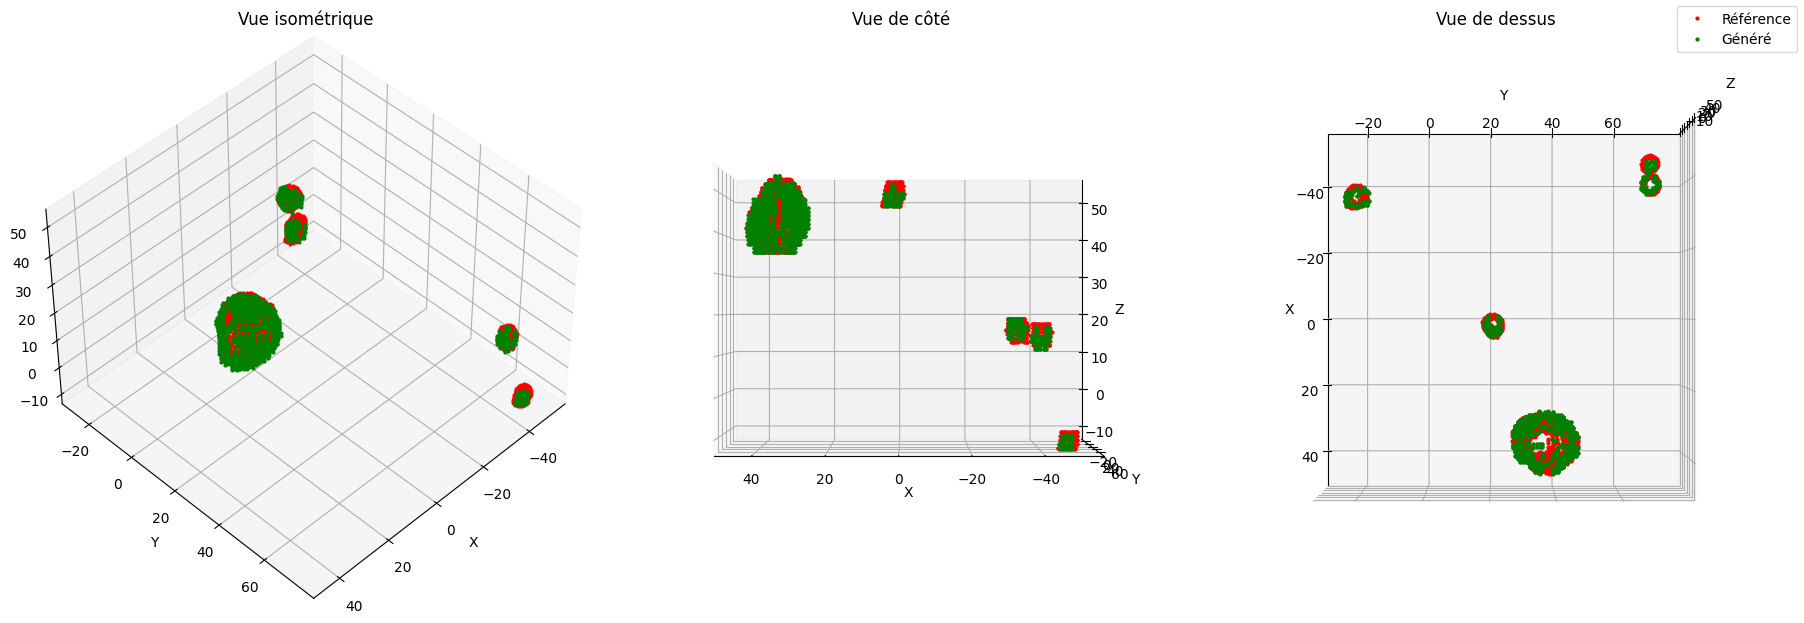

In [15]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_dicom_rtstruct(filepath):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour in contour_data:
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours

def plot_3d_contours_multiple_views(contours_ref, contours_gen):
    fig = plt.figure(figsize=(18, 6))
    
    views = [(45, 45), (90, 0), (0, 90)]
    titles = ['Vue isométrique', 'Vue de côté', 'Vue de dessus']
    
    for i, (azim, elev) in enumerate(views):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        for contour in contours_ref:
            x = contour[:, 0]
            y = contour[:, 1]
            z = contour[:, 2]
            ax.plot(x, y, z, 'o', markersize=2, color='red', label='Référence' if contour is contours_ref[0] else "")

        for contour in contours_gen:
            x = contour[:, 0]
            y = contour[:, 1]
            z = contour[:, 2]
            ax.plot(x, y, z, 'o', markersize=2, color='green', label='Généré' if contour is contours_gen[0] else "")

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(titles[i])
        ax.view_init(elev=elev, azim=azim)
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()

dicom_reference_rtstruct_path = 'official.dcm'
dicom_generated_rtstruct_path = 'fromMetIA.dcm'

contours_original = read_dicom_rtstruct(dicom_reference_rtstruct_path)
contours_generated = read_dicom_rtstruct(dicom_generated_rtstruct_path)

plot_3d_contours_multiple_views(contours_original, contours_generated)

# Visualisation avec matplotlib pour vérifier que les masques sont bons pour le calcul des stats d'intensité

In [ ]:
def afficher_slices_avec_rois(volumes_roi, roi_type, num_slices):
    """
    Affiche les slices qui comportent des ROIs non vides en ajustant le numéro de la slice.
    
    Args:
        volumes_roi (dict): Dictionnaire contenant les volumes pour chaque ROI.
        roi_type (str): Type de ROI ('Original' ou 'Generated').
        num_slices (int): Nombre total de slices dans la série DICOM.
    """
    for roi_name, volume in volumes_roi.items():
        print(f"Affichage des slices pour {roi_name} ({roi_type}):")
        
        for z in range(volume.shape[2]):
            # verif si la slice contient des valeurs non nulles
            if np.any(volume[:, :, z] > 0):
                slice_number = num_slices - z
                plt.figure(figsize=(6, 6))
                plt.imshow(volume[:, :, z], cmap='gray')
                plt.title(f'{roi_name} ({roi_type}) - Slice {slice_number}')
                plt.axis('on')
                plt.show()

print("Slices avec des ROIs - RTStruct Original:")
afficher_slices_avec_rois(volumes_roi_original, "Original", len_dicoms)

print("\nSlices avec des ROIs - RTStruct Generated:")
afficher_slices_avec_rois(volumes_roi_generated, "Generated", len_dicoms)

# My miscellaneous experiments for do this job

J'ai utilisé from scipy.ndimage import distance_transform_edt pour faire mes calculs de tolérance, ça permet de calculer la transformée de distance euclidienne d'une image binaire, 

Qu'est-ce que la Transformée de Distance Euclidienne (EDT) ?
La transformée de distance euclidienne est une opération qui transforme une image binaire — composée de pixels de fond (0s) et de pixels d'objet (1s) — en une image où chaque pixel de fond reçoit une valeur correspondant à la distance euclidienne la plus courte entre ce pixel et le pixel de l'objet le plus proche.

Donc c'est très utile pour intégrer des seuils de tolérance dans les métriques

## Explications des Métriques de Similarité

### 1. **Dice Similarity Coefficient (DSC)**
Le **Dice Similarity Coefficient**, également connu sous le nom d'indice de Sørensen-Dice, mesure la similarité entre deux ensembles. Il est formulé comme deux fois le nombre de pixels (ou voxels) en intersection, divisé par la somme des pixels dans chaque image. Cette métrique est très utilisée en analyse d'images pour comparer la similarité spatiale entre deux images segmentées.

```markdown
DSC = (2 * |X ∩ Y|) / (|X| + |Y|)
```
- **X** et **Y** représentent les volumes binaires des deux segmentations.
- L'intersection (X ∩ Y) indique les pixels où les deux segmentations coïncident.
- Les valeurs proches de 1 indiquent une grande similarité, tandis que les valeurs proches de 0 indiquent peu ou pas de similarité.

### 2. **Mean Surface Distance (MSD)**
La **Mean Surface Distance** calcule la distance moyenne entre les bords des deux volumes segmentés. Cette mesure est particulièrement utile pour évaluer la précision des contours des objets segmentés, un aspect crucial dans les applications médicales où la précision des contours peut influencer le diagnostic ou le traitement.

```markdown
MSD = (Σ d(p1, P2) + Σ d(p2, P1)) / (n1 + n2)
```
- **d(p1, P2)** est la distance minimale de chaque point p1 sur le contour du premier volume à l'ensemble de points P2 du second volume.
- **n1** et **n2** sont les nombres de points sur chaque contour.
- Les valeurs faibles de MSD indiquent une grande précision des contours entre les segmentations comparées.

### 3. **Volume Overlap Error (VOE)**
Le **Volume Overlap Error** mesure le degré de chevauchement entre deux volumes segmentés. C'est une métrique complémentaire au DSC et est souvent utilisée pour quantifier l'erreur de chevauchement, ce qui peut aider à comprendre les erreurs de sous ou de sur-segmentation.

```markdown
VOE = 1 - (|X ∩ Y| / |X ∪ Y|)
```
- **X ∪ Y** représente l'union des volumes des deux segmentations.
- Des valeurs proches de 0 indiquent un chevauchement presque parfait, tandis que des valeurs plus élevées indiquent moins de chevauchement.

### 4. **Hausdorff Distance (HD)**
La **Hausdorff Distance** mesure la plus grande distance de tous les points d'un contour segmenté à l'autre, fournissant une mesure de la plus grande erreur possible entre les deux segmentations. Cette métrique est cruciale pour identifier des cas où la segmentation est globalement précise mais contient des erreurs extrêmes.

```markdown
HD = max(h(X, Y), h(Y, X))
```
- **h(X, Y)** est la distance Hausdorff de X vers Y, calculée comme le maximum des distances minimales de chaque point de X à Y.
- Une valeur élevée peut indiquer des erreurs significatives, même si d'autres mesures de similarité semblent acceptables.

### 5. **Jaccard Index**
Le **Jaccard Index** est une mesure de similarité entre deux ensembles, calculée comme la taille de l'intersection divisée par la taille de l'union des deux ensembles. Semblable au DSC, mais sans le facteur de multiplication par deux, ce qui le rend plus sensible aux différences.

```markdown
Jaccard = |X ∩ Y| / |X ∪ Y|
```
- Des valeurs proches de 1 indiquent une forte similarité, tandis que des valeurs proches de 0 indiquent une dissimilarité.

### 6. **Variation of Information (VI)**
La **Variation of Information** est une métrique de la théorie de l'information qui quantifie la quantité d'information perdue et gagnée lors du passage d'une segmentation à une autre. Cela permet d'évaluer la quantité d'information exclusive à chaque segmentation et leur redondance.

```markdown
VI = H(X) + H(Y) - 2I(X, Y)
```
- **H(X)** et **H(Y)** sont les entropies des segmentations, et **I(X, Y)** est l'information mutuelle entre X et Y.
- Des valeurs basses indiquent que les segmentations partagent beaucoup d'information, tandis que des valeurs élevées indiquent une divergence importante.

### 7. **Cosine Similarity**
La **Cosine Similarity** mesure le cosinus de l'angle entre deux vecteurs d'attributs dans un espace multidimensionnel. Dans le contexte de la segmentation, elle compare la similitude de direction entre les vecteurs formés à partir des images segmentées.

```markdown
Cosine Similarity = (X • Y) / (||X|| ||Y||)
```
- **X • Y** est le produit scalaire des vecteurs, et **||X||**, **||Y||** sont les normes de ces vecteurs.
- Des valeurs proches de 1 indiquent une grande similarité.

Ces métriques fournissent une évaluation complète de la qualité des segmentations en tenant compte de différents aspects de la similarité et de l'exactitude des formes segmentées.

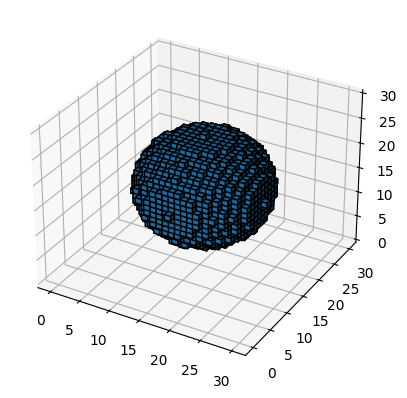

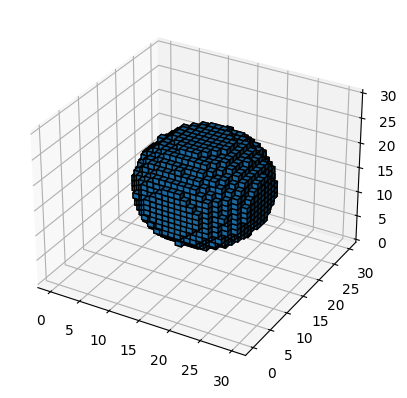

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_3d_volume(shape, sphere_radius):
    """
    Crée un volume 3D binaire avec des zéros partout et une sphère de 1 au milieu.
    """
    volume = np.zeros(shape, dtype=np.uint8)
    center = np.array(shape) // 2
    
    for x in range(shape[0]):
        for y in range(shape[1]):
            for z in range(shape[2]):
                if np.linalg.norm(np.array([x, y, z]) - center) <= sphere_radius:
                    volume[x, y, z] = 1
    
    return volume

def plot_3d_volume(volume):
    """
    Affiche le volume 3D en utilisant matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.voxels(volume, edgecolor='k')
    
    plt.show()

# Dimensions du volume 3D (par exemple, 30x30x30)
shape = (30, 30, 30)
# Rayon de la sphère au centre du volume
sphere_radius = 10

# Crée le volume 3D
volume1 = create_3d_volume(shape, sphere_radius)
volume2 = create_3d_volume(shape, sphere_radius - 0.1)

# Affiche le volume 3D
plot_3d_volume(volume1)
plot_3d_volume(volume2)


In [10]:
print(volume1.shape)

(30, 30, 30)


In [18]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_3d_volume(shape, sphere_radius):
    """
    Crée un volume 3D binaire avec des zéros partout et une sphère de 1 au milieu.
    """
    volume = np.zeros(shape, dtype=np.uint8)
    center = np.array(shape) // 2
    
    for x in range(shape[0]):
        for y in range(shape[1]):
            for z in range(shape[2]):
                if np.linalg.norm(np.array([x, y, z]) - center) <= sphere_radius:
                    volume[x, y, z] = 1
    
    return volume

def calculate_ssim_3d(volume1, volume2):
    """
    Calcule la SSIM entre deux volumes 3D.
    """
    ssim_index = 0
    count = 0
    
    # Parcours des tranches le long de l'axe z
    for z in range(volume1.shape[2]):
        ssim_index += ssim(volume1[:, :, z], volume2[:, :, z], data_range=volume1.max() - volume1.min())
        count += 1
    
    return ssim_index / count


ssim_index = calculate_ssim_3d(volume1, volume2)
print(f'SSIM Index: {ssim_index}')


SSIM Index: 0.9589564643092673


Contour 0:
[[ 4.064895  22.80843   47.77951  ]
 [ 4.872766  22.13117   47.77951  ]
 [ 5.038352  21.1903    47.77951  ]
 [ 4.98927   20.37592   47.77951  ]
 [ 4.325519  19.64703   47.77951  ]
 [ 3.47629   19.37649   47.77951  ]
 [ 1.469513  19.22034   47.77951  ]
 [ 0.663972  19.44009   47.77951  ]
 [ 0.1556445 19.89163   47.77951  ]
 [-0.2176661 20.51037   47.77951  ]
 [-0.2619112 21.35265   47.77951  ]
 [ 0.2937662 22.33735   47.77951  ]
 [ 0.8349229 22.69546   47.77951  ]
 [ 1.766603  22.88464   47.77951  ]
 [ 2.978683  22.88169   47.77951  ]]

Contour 1:
[[ 5.032926   21.31103    48.77951   ]
 [ 4.715748   20.30418    48.77951   ]
 [ 4.477738   19.97147    48.77951   ]
 [ 3.88162    19.497      48.77951   ]
 [ 3.001421   19.21054    48.77951   ]
 [ 1.427195   19.12189    48.77951   ]
 [ 0.6355689  19.37739    48.77951   ]
 [-0.1920465  20.14381    48.77951   ]
 [-0.4030024  20.89533    48.77951   ]
 [-0.273221   21.70031    48.77951   ]
 [ 0.08243378 22.35151    48.77951   ]
 [ 0.50

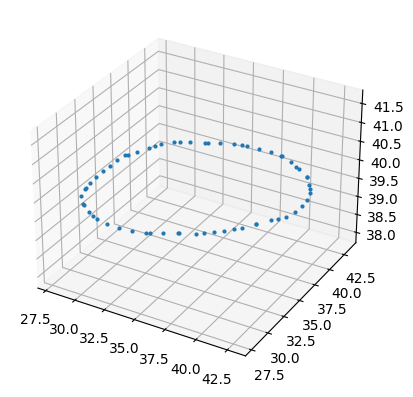

In [3]:
import pydicom
import numpy as np

def read_dicom_rtstruct(filepath):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    

    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour in contour_data:
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours


dicom_rtstruct_path = 'rtstruct.dcm'
contours = read_dicom_rtstruct(dicom_rtstruct_path)

for i, contour in enumerate(contours):
    print(f"Contour {i}:")
    print(contour)
    print()


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_contour(contour):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = contour[:, 0]
    y = contour[:, 1]
    z = contour[:, 2]
    
    ax.plot(x, y, z, 'o', markersize=2)
    plt.show()

# Afficher le premier contour pour exemple
if contours:
    plot_3d_contour(contours[34])


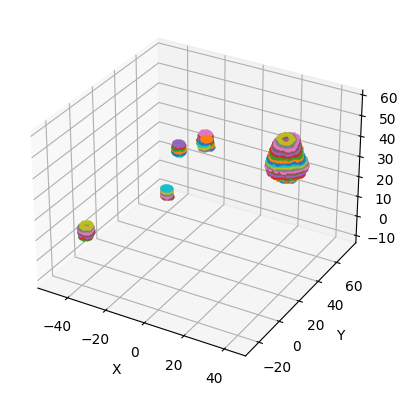

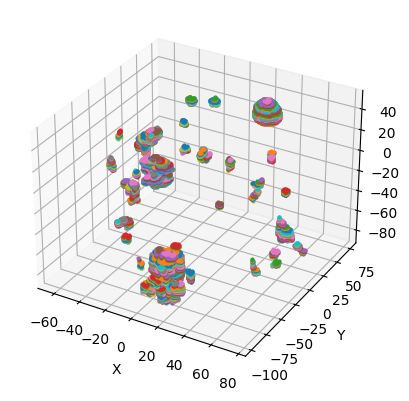

In [4]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_dicom_rtstruct(filepath):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour in contour_data:
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours

def plot_3d_contours(contours):
    """
    Affiche les contours 3D en utilisant matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        z = contour[:, 2]
        ax.plot(x, y, z, 'o', markersize=2)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

dicom_rtstruct_path = 'rtstruct.dcm'
dicom_rtstruct_path_generated = 'rtstructGeneratedAl.dcm'
contours_original = read_dicom_rtstruct(dicom_rtstruct_path)
plot_3d_contours(contours)

contours_generated = read_dicom_rtstruct(dicom_rtstruct_path_generated)
plot_3d_contours(contours_generated)

In [57]:
import os
import pydicom

def load_dicom_files(directory):
    """
    Charge tous les fichiers DICOM d'un répertoire.
    
    Args:
        directory (str): Le chemin du répertoire contenant les fichiers DICOM.
        
    Returns:
        list: Une liste d'objets pydicom représentant les fichiers DICOM.
    """
    dicom_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.dcm'):
                filepath = os.path.join(root, file)
                dicom_files.append(pydicom.dcmread(filepath))
    return dicom_files

directory_path = './IRM'

dicom_files = load_dicom_files(directory_path)

len_dicoms = len(dicom_files)
print(f"Nombre de fichiers DICOM chargés: {len_dicoms}")
rows = dicom_files[0].Rows
columns = dicom_files[0].Columns
thickness = dicom_files[0].SliceThickness
imagePositionPatient = dicom_files[0].ImagePositionPatient
pixelSpacing = dicom_files[0].PixelSpacing

shape = (rows, columns, len_dicoms)
print(f"Dimensions des images DICOM: {rows} x {columns} x {len_dicoms}")
print(f"Épaisseur de coupe: {thickness} mm")
print(f"Position du patient: {imagePositionPatient}")
print(f"Espacement des pixels: {pixelSpacing}")

Nombre de fichiers DICOM chargés: 208
Dimensions des images DICOM: 512 x 512 x 208
Épaisseur de coupe: 1 mm
Position du patient: [-127.10413622811, -129.77906539796, -44.220491945744]
Espacement des pixels: [0.5, 0.5]


Temps d'exécution: 0.01 secondes
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


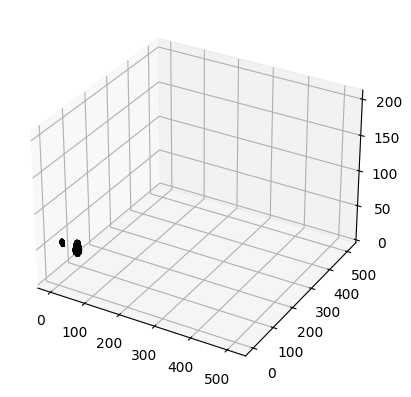

In [46]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import time

def contours_to_volume(contours, shape):
    """
    Convertit une liste de contours en un volume 3D binaire.
    """
    volume = np.zeros(shape, dtype=np.uint8)
    for contour in contours:
        for point in contour:
            x, y, z = map(int, point)
            if 0 <= x < shape[0] and 0 <= y < shape[1] and 0 <= z < shape[2]:
                volume[x, y, z] = 1
    return volume

def plot_3d_volume(volume):
    """
    Affiche le volume 3D en utilisant matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.voxels(volume, edgecolor='k')
    
    plt.show()

volume = contours_to_volume(contours_original, shape)
plot_3d_volume(volume)


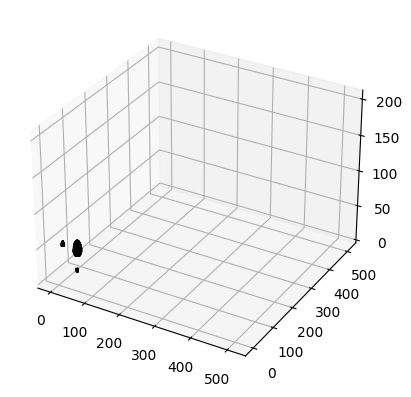

In [47]:
volume2 = contours_to_volume(contours_generated, shape)
plot_3d_volume(volume2)

Nombre de fichiers DICOM chargés: 208
Dimensions des images DICOM: 512 x 512 x 208


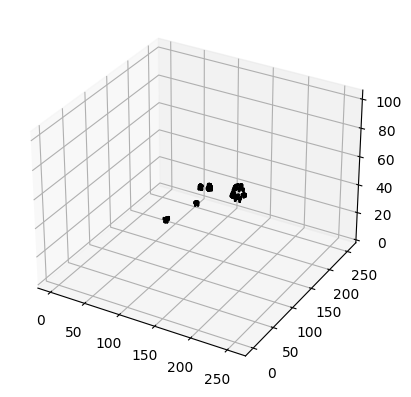

In [2]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def load_dicom_files(directory):
    """
    Charge tous les fichiers DICOM d'un répertoire.
    
    Args:
        directory (str): Le chemin du répertoire contenant les fichiers DICOM.
        
    Returns:
        list: Une liste d'objets pydicom représentant les fichiers DICOM.
    """
    dicom_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.dcm'):
                filepath = os.path.join(root, file)
                dicom_files.append(pydicom.dcmread(filepath))
    return dicom_files

def read_dicom_rtstruct(filepath):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    
    # Vérifie que le fichier est un RT Structure Set
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour in contour_data:
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours

def convert_contours_to_voxel_space(contours, dicom_files):
    """
    Convertit les coordonnées des contours en coordonnées de voxels.
    
    Args:
        contours (list): Liste des contours.
        dicom_files (list): Liste des fichiers DICOM.
        
    Returns:
        list: Liste des contours convertis en coordonnées de voxels.
    """
    pixel_spacing = dicom_files[0].PixelSpacing
    slice_thickness = dicom_files[0].SliceThickness
    image_position_patient = dicom_files[0].ImagePositionPatient

    contours_voxel_space = []

    for contour in contours:
        voxel_contour = []
        for point in contour:
            x_mm, y_mm, z_mm = point
            x_voxel = int((x_mm - image_position_patient[0]) / pixel_spacing[0])
            y_voxel = int((y_mm - image_position_patient[1]) / pixel_spacing[1])
            z_voxel = int((z_mm - image_position_patient[2]) / slice_thickness)
            voxel_contour.append((x_voxel, y_voxel, z_voxel))
        contours_voxel_space.append(np.array(voxel_contour))
    
    return contours_voxel_space

def contours_to_volume(contours, shape):
    """
    Convertit une liste de contours en un volume 3D binaire.
    """
    volume = np.zeros(shape, dtype=np.uint8)
    for contour in contours:
        for point in contour:
            x, y, z = map(int, point)
            if 0 <= x < shape[0] and 0 <= y < shape[1] and 0 <= z < shape[2]:
                volume[x, y, z] = 1
    return volume

def plot_3d_volume(volume):
    """
    Affiche le volume 3D en utilisant matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.voxels(volume, edgecolor='k')
    
    plt.show()

directory_path = './IRM'
dicom_files = load_dicom_files(directory_path)

len_dicoms = len(dicom_files)
print(f"Nombre de fichiers DICOM chargés: {len_dicoms}")
rows = dicom_files[0].Rows
columns = dicom_files[0].Columns

shape = (rows, columns, len_dicoms)
print(f"Dimensions des images DICOM: {rows} x {columns} x {len_dicoms}")

rtstruct_path = 'rtstruct.dcm'

contours = read_dicom_rtstruct(rtstruct_path)

contours_voxel_space = convert_contours_to_voxel_space(contours, dicom_files)

volume_original = contours_to_volume(contours_voxel_space, shape)

# Downsample le volume pour un affichage plus rapide (facultatif)
downsample_factor = 0.5  
volume_downsampled = zoom(volume_original, (downsample_factor, downsample_factor, downsample_factor), order=0)

plot_3d_volume(volume_downsampled)


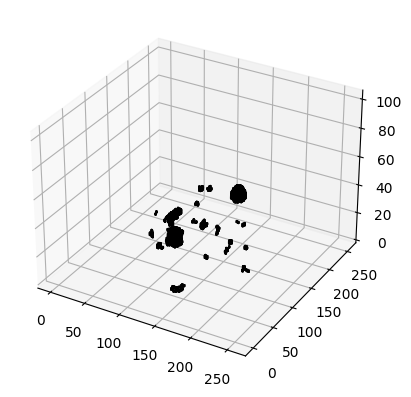

In [3]:
rtstruct_path = 'rtstructGeneratedAl.dcm'
rtstruct_path2 = 'generated2.dcm'

contours = read_dicom_rtstruct(rtstruct_path)
contours2 = read_dicom_rtstruct(rtstruct_path2)

contours_voxel_space = convert_contours_to_voxel_space(contours, dicom_files)


volume_generated = contours_to_volume(contours_voxel_space, shape)
contours_voxel_space2 = convert_contours_to_voxel_space(contours2, dicom_files)
volume_generated2 = contours_to_volume(contours_voxel_space2, shape)


downsample_factor = 0.5 
volume_downsampled = zoom(volume_generated, (downsample_factor, downsample_factor, downsample_factor), order=0)


plot_3d_volume(volume_downsampled)

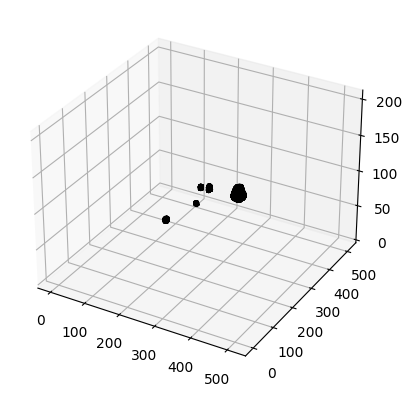

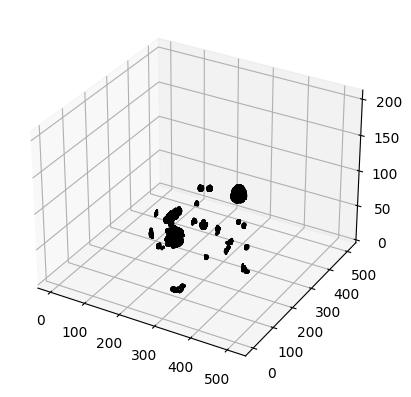

In [69]:
plot_3d_volume(volume_original)
plot_3d_volume(volume_generated)

In [8]:
import numpy as np
from scipy.spatial.distance import cdist

def dice_coefficient(volume1, volume2):
    """
    Calcule le Dice Similarity Coefficient entre deux volumes 3D binaires.
    
    Args:
        volume1 (np.array): Premier volume 3D binaire.
        volume2 (np.array): Deuxième volume 3D binaire.
        
    Returns:
        float: Dice Similarity Coefficient.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    return (2. * intersection) / (size1 + size2)

def hausdorff_distance_yes(volume1, volume2):
    """
    Calcule la distance de Hausdorff entre deux volumes 3D binaires.
    
    Args:
        volume1 (np.array): Premier volume 3D binaire.
        volume2 (np.array): Deuxième volume 3D binaire.
        
    Returns:
        float: Hausdorff Distance.
    """
    points1 = np.array(np.where(volume1 > 0)).T
    points2 = np.array(np.where(volume2 > 0)).T
    
    # Calcul des distances de chaque point de points1 aux points de points2
    d1 = cdist(points1, points2, metric='euclidean')
    d2 = cdist(points2, points1, metric='euclidean')
    
    # Calcul de la distance maximale
    hd1 = np.max(np.min(d1, axis=1))
    hd2 = np.max(np.min(d2, axis=1))
    return np.maximum(hd1, hd2)


dsc_value = dice_coefficient(volume_original, volume_generated)
print(f'Dice Similarity Coefficient entre les deux volumes 3D: {dsc_value}')


hd_value = hausdorff_distance_yes(volume_original, volume_generated)
print(f'Hausdorff Distance entre les deux volumes 3D: {hd_value}')


Dice Similarity Coefficient entre les deux volumes 3D: 0.05776868455891202
Hausdorff Distance entre les deux volumes 3D: 150.41608956491322


Dice Similarity Coefficient entre les deux volumes 3D: 0.2638121546961326
Hausdorff Distance entre les deux volumes 3D: 3.0


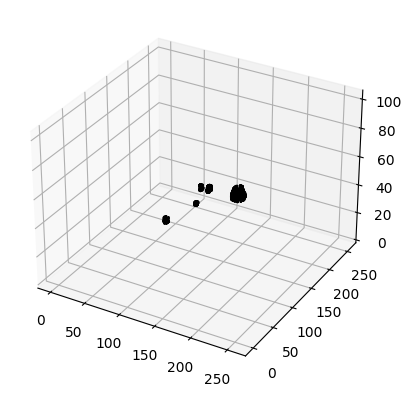

In [9]:
rtstruct_path_modified = 'rtss2.dcm'

contours_modified = read_dicom_rtstruct(rtstruct_path_modified)

contours_voxel_space_modified = convert_contours_to_voxel_space(contours_modified, dicom_files)

volume_modified = contours_to_volume(contours_voxel_space_modified, shape)
dsc_value = dice_coefficient(volume_original, volume_modified)
print(f'Dice Similarity Coefficient entre les deux volumes 3D: {dsc_value}')

hd_value = hausdorff_distance_yes(volume_original, volume_modified)
print(f'Hausdorff Distance entre les deux volumes 3D: {hd_value}')
downsample_factor = 0.5  # Réduire la taille du volume par ce facteur
volume_downsampled_modified = zoom(volume_modified, (downsample_factor, downsample_factor, downsample_factor), order=0)

plot_3d_volume(volume_downsampled_modified)

In [10]:
import numpy as np
from scipy.spatial.distance import cdist

def dice_coefficient(volume1, volume2):
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    return (2. * intersection) / (size1 + size2)

def mean_surface_distance(volume1, volume2):
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    d1 = cdist(points1, points2, metric='euclidean')
    d2 = cdist(points2, points1, metric='euclidean')
    msd1 = np.mean(np.min(d1, axis=1))
    msd2 = np.mean(np.min(d2, axis=1))
    return (msd1 + msd2) / 2

def volume_overlap_error(volume1, volume2):
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    union = np.sum((volume1 > 0) | (volume2 > 0))
    return 1 - (intersection / union)

dsc_value = dice_coefficient(volume_original, volume_generated2)
print(f'Dice Similarity Coefficient entre les deux volumes 3D: {dsc_value}')

msd_value = mean_surface_distance(volume_original, volume_generated2)
print(f'Mean Surface Distance entre les deux volumes 3D: {msd_value}')

voe_value = volume_overlap_error(volume_original, volume_generated2)
print(f'Volume Overlap Error entre les deux volumes 3D: {voe_value}')

hd_value = hausdorff_distance_yes(volume_original, volume_generated2)
print(f'Hausdorff Distance entre les deux volumes 3D: {hd_value}')

Dice Similarity Coefficient entre les deux volumes 3D: 0.13578500707213578
Mean Surface Distance entre les deux volumes 3D: 3.773272501474935
Volume Overlap Error entre les deux volumes 3D: 0.9271623672230652
Hausdorff Distance entre les deux volumes 3D: 86.09878047916823


In [11]:
from scipy.ndimage import binary_erosion

def extract_surface(volume):
    """
    Extrait la surface d'un volume binaire en 3D.
    """
    eroded_volume = binary_erosion(volume)
    surface = volume & ~eroded_volume
    return surface

def boundary_overlap(surface1, surface2):
    """
    Calcule la superposition des frontières des contours en 3D.
    """
    intersection = np.sum((surface1 > 0) & (surface2 > 0))
    size1 = np.sum(surface1 > 0)
    size2 = np.sum(surface2 > 0)
    return intersection / (size1 + size2 - intersection)

surface1 = extract_surface(volume_original)
surface2 = extract_surface(volume_generated2)

bo_value = boundary_overlap(surface1, surface2)
print(f'Boundary Overlap entre les deux surfaces: {bo_value}')

Boundary Overlap entre les deux surfaces: 0.07283763277693475


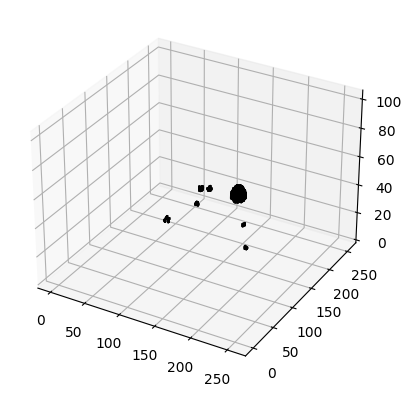

In [117]:
downsample_factor = 0.5 
volume_downsampled_generated2 = zoom(volume_generated2, (downsample_factor, downsample_factor, downsample_factor), order=0)

plot_3d_volume(volume_downsampled_generated2)

In [12]:
from sklearn.neighbors import NearestNeighbors

def shape_context_descriptors(contour, n_bins=12, r_inner=0.125, r_outer=2.0):
    """
    Calcule les descripteurs de contexte de forme pour un ensemble de points de contour en 3D.
    """
    histograms = []
    for point in contour:
        relative_coords = contour - point
        distances = np.sqrt((relative_coords ** 2).sum(axis=1))
        angles = np.arctan2(relative_coords[:, 1], relative_coords[:, 0])
        angles = (angles + 2 * np.pi) % (2 * np.pi)  # angles in [0, 2*pi]

        log_distances = np.log(distances + 1e-6)
        hist, _, _ = np.histogram2d(log_distances, angles, bins=[n_bins, n_bins],
                                    range=[[np.log(r_inner), np.log(r_outer)], [0, 2 * np.pi]])
        histograms.append(hist.flatten())
    return np.array(histograms)

def shape_context_distance(desc1, desc2):
    """
    Calcule la distance de contexte de forme entre deux ensembles de descripteurs.
    """
    nbrs = NearestNeighbors(n_neighbors=1).fit(desc2)
    distances, _ = nbrs.kneighbors(desc1)
    return np.mean(distances)

def mean_shape_context_distance(volume1, volume2):
    """
    Calcule la distance moyenne de contexte de forme entre deux volumes binaires en 3D.
    """
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    
    desc1 = shape_context_descriptors(points1)
    desc2 = shape_context_descriptors(points2)
    
    return shape_context_distance(desc1, desc2)


msc_distance = mean_shape_context_distance(volume_original, volume_generated2)
print(f'Mean Shape Context Distance entre les deux volumes: {msc_distance}')


Mean Shape Context Distance entre les deux volumes: 1.1815817706137102


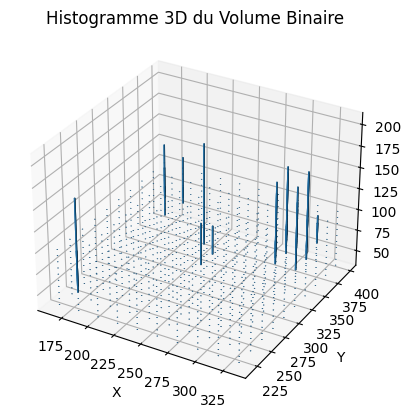

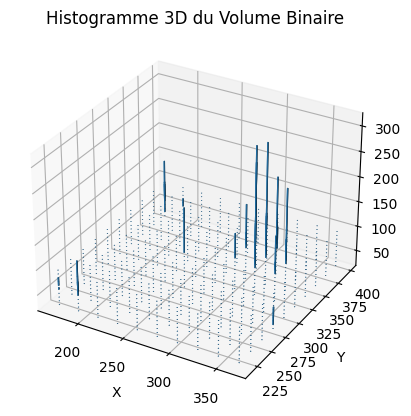

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_histogram_3d(volume):
    """
    Affiche un histogramme 3D d'un volume binaire.
    
    Args:
        volume (np.array): Volume 3D binaire.
    """

    points = np.argwhere(volume > 0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    hist, edges = np.histogramdd(points, bins=(10, 10, 10))
    
    x_edges, y_edges, z_edges = edges
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    z_centers = (z_edges[:-1] + z_edges[1:]) / 2
    
    x_pos, y_pos, z_pos = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")
    x_pos = x_pos.flatten()
    y_pos = y_pos.flatten()
    z_pos = z_pos.flatten()
    hist = hist.flatten()
    
    ax.bar3d(x_pos, y_pos, z_pos, 1, 1, hist, shade=True)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Histogramme 3D du Volume Binaire')
    
    plt.show()


plot_histogram_3d(volume_original)
plot_histogram_3d(volume_generated2)


In [18]:
import numpy as np
from scipy.spatial.distance import cdist, directed_hausdorff
from scipy.ndimage import binary_erosion
from sklearn.metrics import mutual_info_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

def dice_coefficient(volume1, volume2):
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    return (2. * intersection) / (size1 + size2)

def mean_surface_distance(volume1, volume2):
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    d1 = cdist(points1, points2, metric='euclidean')
    d2 = cdist(points2, points1, metric='euclidean')
    msd1 = np.mean(np.min(d1, axis=1))
    msd2 = np.mean(np.min(d2, axis=1))
    return (msd1 + msd2) / 2

def volume_overlap_error(volume1, volume2):
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    union = np.sum((volume1 > 0) | (volume2 > 0))
    return 1 - (intersection / union)

def hausdorff_distance(volume1, volume2):
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    hd1 = directed_hausdorff(points1, points2)[0]
    hd2 = directed_hausdorff(points2, points1)[0]
    return max(hd1, hd2)

def jaccard_index(volume1, volume2):
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    union = np.sum((volume1 > 0) | (volume2 > 0))
    return intersection / union

def tanimoto_coefficient(volume1, volume2):
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    return intersection / (size1 + size2 - intersection)

def variation_of_information(volume1, volume2):
    volume1_flat = volume1.flatten()
    volume2_flat = volume2.flatten()
    h1 = mutual_info_score(volume1_flat, volume1_flat)
    h2 = mutual_info_score(volume2_flat, volume2_flat)
    mi = mutual_info_score(volume1_flat, volume2_flat)
    return h1 + h2 - 2 * mi

def matthews_correlation_coefficient(volume1, volume2):
    tp = np.sum((volume1 > 0) & (volume2 > 0))
    tn = np.sum((volume1 == 0) & (volume2 == 0))
    fp = np.sum((volume1 == 0) & (volume2 > 0))
    fn = np.sum((volume1 > 0) & (volume2 == 0))
    
    numerator = tp * tn - fp * fn
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    if denominator == 0:
        return 0  # Eviter la division par zéro
    return numerator / denominator

def cosine_similarity_3d(volume1, volume2):
    volume1_flat = volume1.flatten().reshape(1, -1)
    volume2_flat = volume2.flatten().reshape(1, -1)
    return cosine_similarity(volume1_flat, volume2_flat)[0][0]

def similarity_metrics(volume1, volume2):
    metrics = {
        'Dice Similarity Coefficient': dice_coefficient(volume1, volume2),
        'Mean Surface Distance': mean_surface_distance(volume1, volume2),
        'Volume Overlap Error': volume_overlap_error(volume1, volume2),
        'Hausdorff Distance': hausdorff_distance(volume1, volume2),
        'Jaccard Index': jaccard_index(volume1, volume2),
        'Tanimoto Coefficient': tanimoto_coefficient(volume1, volume2),
        'Variation of Information': variation_of_information(volume1, volume2),
        'Matthews Correlation Coefficient': matthews_correlation_coefficient(volume1, volume2),
        'Cosine Similarity': cosine_similarity_3d(volume1, volume2)
    }
    return metrics

metrics = similarity_metrics(volume_original, volume_generated2)

for metric, value in metrics.items():
    print(f'{metric}: {value}')


/var/folders/jg/t9vqq9854pxch7qvzwqnc2d40000gn/T/ipykernel_62311/2997402987.py:60: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


Dice Similarity Coefficient: 0.13578500707213578
Mean Surface Distance: 3.773272501474935
Volume Overlap Error: 0.9271623672230652
Hausdorff Distance: 86.09878047916823
Jaccard Index: 0.07283763277693475
Tanimoto Coefficient: 0.07283763277693475
Variation of Information: 0.0006682322525809815
Matthews Correlation Coefficient: 8.869089447100631
Cosine Similarity: 0.13720348647902542


In [35]:
import numpy as np
from scipy.spatial.distance import cdist, directed_hausdorff
from scipy.ndimage import binary_erosion, distance_transform_edt
from sklearn.metrics import mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

def dice_coefficient(volume1, volume2, gap_error=0):
    if gap_error > 0:
        volume1_dilated = distance_transform_edt(volume1 == 0) <= gap_error
        volume2_dilated = distance_transform_edt(volume2 == 0) <= gap_error
        intersection = np.sum((volume1_dilated > 0) & (volume2 > 0)) + np.sum((volume2_dilated > 0) & (volume1 > 0))
        intersection /= 2
    else:
        intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    return (2. * intersection) / (size1 + size2)

def mean_surface_distance(volume1, volume2, gap_error=0):
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    if gap_error > 0:
        volume1_dilated = distance_transform_edt(volume1 == 0) <= gap_error
        volume2_dilated = distance_transform_edt(volume2 == 0) <= gap_error
        points1_dilated = np.argwhere(volume1_dilated > 0)
        points2_dilated = np.argwhere(volume2_dilated > 0)
        d1 = cdist(points1, points2_dilated, metric='euclidean')
        d2 = cdist(points2, points1_dilated, metric='euclidean')
    else:
        d1 = cdist(points1, points2, metric='euclidean')
        d2 = cdist(points2, points1, metric='euclidean')
    msd1 = np.mean(np.min(d1, axis=1))
    msd2 = np.mean(np.min(d2, axis=1))
    return (msd1 + msd2) / 2

def volume_overlap_error(volume1, volume2, gap_error=0):
    if gap_error > 0:
        volume1_dilated = distance_transform_edt(volume1 == 0) <= gap_error
        volume2_dilated = distance_transform_edt(volume2 == 0) <= gap_error
        intersection = np.sum((volume1_dilated > 0) & (volume2 > 0)) + np.sum((volume2_dilated > 0) & (volume1 > 0))
        intersection /= 2
    else:
        intersection = np.sum((volume1 > 0) & (volume2 > 0))
    union = np.sum((volume1 > 0) | (volume2 > 0))
    return 1 - (intersection / union)

def hausdorff_distance(volume1, volume2, gap_error=0):
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    if gap_error > 0:
        volume1_dilated = distance_transform_edt(volume1 == 0) <= gap_error
        volume2_dilated = distance_transform_edt(volume2 == 0) <= gap_error
        points1_dilated = np.argwhere(volume1_dilated > 0)
        points2_dilated = np.argwhere(volume2_dilated > 0)
        hd1 = directed_hausdorff(points1, points2_dilated)[0]
        hd2 = directed_hausdorff(points2, points1_dilated)[0]
    else:
        hd1 = directed_hausdorff(points1, points2)[0]
        hd2 = directed_hausdorff(points2, points1)[0]
    return max(hd1, hd2)


def jaccard_index(volume1, volume2, gap_error=0):
    if gap_error > 0:
        volume1_dilated = distance_transform_edt(volume1 == 0) <= gap_error
        volume2_dilated = distance_transform_edt(volume2 == 0) <= gap_error
        intersection = np.sum((volume1_dilated > 0) & (volume2_dilated > 0))
        union = np.sum((volume1_dilated > 0) | (volume2_dilated > 0))
    else:
        intersection = np.sum((volume1 > 0) & (volume2 > 0))
        union = np.sum((volume1 > 0) | (volume2 > 0))
    return intersection / union if union != 0 else 0

def tanimoto_coefficient(volume1, volume2, gap_error=0):
    if gap_error > 0:
        volume1_dilated = distance_transform_edt(volume1 == 0) <= gap_error
        volume2_dilated = distance_transform_edt(volume2 == 0) <= gap_error
        intersection = np.sum((volume1_dilated > 0) & (volume2_dilated > 0))
        size1 = np.sum(volume1_dilated > 0)
        size2 = np.sum(volume2_dilated > 0)
    else:
        intersection = np.sum((volume1 > 0) & (volume2 > 0))
        size1 = np.sum(volume1 > 0)
        size2 = np.sum(volume2 > 0)
    return intersection / (size1 + size2 - intersection) if (size1 + size2 - intersection) != 0 else 0




def variation_of_information(volume1, volume2, gap_error=0):
    if gap_error > 0:
        volume1_dilated = distance_transform_edt(volume1 == 0) <= gap_error
        volume2_dilated = distance_transform_edt(volume2 == 0) <= gap_error
        volume1 = np.maximum(volume1, volume1_dilated)
        volume2 = np.maximum(volume2, volume2_dilated)
    volume1_flat = volume1.flatten()
    volume2_flat = volume2.flatten()
    h1 = mutual_info_score(volume1_flat, volume1_flat)
    h2 = mutual_info_score(volume2_flat, volume2_flat)
    mi = mutual_info_score(volume1_flat, volume2_flat)
    return h1 + h2 - 2 * mi

def cosine_similarity_3d(volume1, volume2, gap_error=0):
    if gap_error > 0:
        volume1_dilated = distance_transform_edt(volume1 == 0) <= gap_error
        volume2_dilated = distance_transform_edt(volume2 == 0) <= gap_error
        volume1 = np.maximum(volume1, volume1_dilated)
        volume2 = np.maximum(volume2, volume2_dilated)
    volume1_flat = volume1.flatten().reshape(1, -1)
    volume2_flat = volume2.flatten().reshape(1, -1)
    return cosine_similarity(volume1_flat, volume2_flat)[0][0]




def similarity_metrics(volume1, volume2, gap_error=0):
    dsc = dice_coefficient(volume1, volume2, gap_error)
    msd = mean_surface_distance(volume1, volume2, gap_error)
    voe = volume_overlap_error(volume1, volume2, gap_error)
    hd = hausdorff_distance(volume1, volume2, gap_error)
    ji = jaccard_index(volume1, volume2, gap_error) 
    tc = tanimoto_coefficient(volume1, volume2, gap_error)
    vi = variation_of_information(volume1, volume2, gap_error)
    cs = cosine_similarity_3d(volume1, volume2, gap_error)
    
    return {
        'Dice Similarity Coefficient': dsc,
        'Mean Surface Distance': msd,
        'Volume Overlap Error': voe,
        'Hausdorff Distance': hd,
        'Jaccard Index': ji,
        'Tanimoto Coefficient': tc,
        'Variation of Information': vi,
        'Cosine Similarity': cs
    }

gap_error = 2

metrics = similarity_metrics(volume_original, volume_generated2, gap_error=gap_error)

for metric, value in metrics.items():
    print(f'{metric}: {value}')


Dice Similarity Coefficient: 0.8002828854314002
Mean Surface Distance: 2.648682749942856
Volume Overlap Error: 0.5707132018209409
Hausdorff Distance: 84.4866853415377
Jaccard Index: 0.4775430583309544
Tanimoto Coefficient: 0.4775430583309544
Variation of Information: 0.002422933908084879
Cosine Similarity: 0.6468568689284693


In [36]:
for gap_error in range(6):
    print(f'\nGap Error: {gap_error}')
    metrics = similarity_metrics(volume_original, volume_generated2, gap_error=gap_error)
    for metric, value in metrics.items():
        print(f'{metric}: {value}')


Gap Error: 0
Dice Similarity Coefficient: 0.13578500707213578
Mean Surface Distance: 3.773272501474935
Volume Overlap Error: 0.9271623672230652
Hausdorff Distance: 86.09878047916823
Jaccard Index: 0.07283763277693475
Tanimoto Coefficient: 0.07283763277693475
Variation of Information: 0.0006682322525809815
Cosine Similarity: 0.13720348647902542

Gap Error: 1
Dice Similarity Coefficient: 0.5077793493635078
Mean Surface Distance: 3.093532390925451
Volume Overlap Error: 0.7276176024279211
Hausdorff Distance: 85.34635317340748
Jaccard Index: 0.2860613695671736
Tanimoto Coefficient: 0.2860613695671736
Variation of Information: 0.0017111670613019882
Cosine Similarity: 0.4454330054290475

Gap Error: 2
Dice Similarity Coefficient: 0.8002828854314002
Mean Surface Distance: 2.648682749942856
Volume Overlap Error: 0.5707132018209409
Hausdorff Distance: 84.4866853415377
Jaccard Index: 0.4775430583309544
Tanimoto Coefficient: 0.4775430583309544
Variation of Information: 0.002422933908084879
Cosine 

In [37]:
for gap_error in range(6):
    print(f'\nGap Error: {gap_error}')
    metrics = similarity_metrics(volume_original, volume_generated, gap_error=gap_error)
    for metric, value in metrics.items():
        print(f'{metric}: {value}')


Gap Error: 0
Dice Similarity Coefficient: 0.05776868455891202
Mean Surface Distance: 21.16601797962102
Volume Overlap Error: 0.970256537365225
Hausdorff Distance: 150.41608956491322
Jaccard Index: 0.029743462634775064
Tanimoto Coefficient: 0.029743462634775064
Variation of Information: 0.001509030684888757
Cosine Similarity: 0.07482617987190415

Gap Error: 1
Dice Similarity Coefficient: 0.21603080996509808
Mean Surface Distance: 20.428337694550347
Volume Overlap Error: 0.8887718428553724
Hausdorff Distance: 149.75313018431368
Jaccard Index: 0.10782484821761693
Tanimoto Coefficient: 0.10782484821761693
Variation of Information: 0.004621897573769733
Cosine Similarity: 0.2399156834424305

Gap Error: 2
Dice Similarity Coefficient: 0.34047418461908774
Mean Surface Distance: 19.82576644965433
Volume Overlap Error: 0.8246994670962945
Hausdorff Distance: 148.7212157024007
Jaccard Index: 0.16870608800887485
Tanimoto Coefficient: 0.16870608800887485
Variation of Information: 0.00820506332863835

In [38]:
res = 0.5 * 0.1
print(res)
metrics = similarity_metrics(volume_original, volume_generated, gap_error=0.1)
for metric, value in metrics.items():
    print(f'{metric}: {value}')

0.05
Dice Similarity Coefficient: 0.05776868455891202
Mean Surface Distance: 21.16601797962102
Volume Overlap Error: 0.970256537365225
Hausdorff Distance: 150.41608956491322
Jaccard Index: 0.029743462634775064
Tanimoto Coefficient: 0.029743462634775064
Variation of Information: 0.001509030684888757
Cosine Similarity: 0.07482617987190415


In [39]:
seuils = [0, 0.1, 0.5, 1, 2, 3]
results = {}
for gap in seuils:
    metrics = similarity_metrics(volume_original, volume_generated, gap_error=gap)
    results[gap] = metrics

for gap, metrics in results.items():
    print(f'Gap Error: {gap}')
    for metric, value in metrics.items():
        print(f'{metric}: {value}')

Gap Error: 0
Dice Similarity Coefficient: 0.05776868455891202
Mean Surface Distance: 21.16601797962102
Volume Overlap Error: 0.970256537365225
Hausdorff Distance: 150.41608956491322
Jaccard Index: 0.029743462634775064
Tanimoto Coefficient: 0.029743462634775064
Variation of Information: 0.001509030684888757
Cosine Similarity: 0.07482617987190415
Gap Error: 0.1
Dice Similarity Coefficient: 0.05776868455891202
Mean Surface Distance: 21.16601797962102
Volume Overlap Error: 0.970256537365225
Hausdorff Distance: 150.41608956491322
Jaccard Index: 0.029743462634775064
Tanimoto Coefficient: 0.029743462634775064
Variation of Information: 0.001509030684888757
Cosine Similarity: 0.07482617987190415
Gap Error: 0.5
Dice Similarity Coefficient: 0.05776868455891202
Mean Surface Distance: 21.16601797962102
Volume Overlap Error: 0.970256537365225
Hausdorff Distance: 150.41608956491322
Jaccard Index: 0.029743462634775064
Tanimoto Coefficient: 0.029743462634775064
Variation of Information: 0.0015090306848

# Calcul des valeurs d'intensités

In [ ]:
import numpy as np
import pydicom
from scipy.ndimage import binary_fill_holes
import os

def fill_contours(volume_binaire):
    """
    Remplit les contours pour obtenir un volume 3D binaire complet pour un ROI.
    
    Args:
        volume_binaire (np.array): Volume 3D binaire avec les contours des ROIs.
    
    Returns:
        np.array: Volume 3D binaire avec les ROIs complètement remplis.
    """
    # Utilisation de binary_fill_holes pour remplir les contours dans chaque slice
    for z in range(volume_binaire.shape[2]):
        volume_binaire[:, :, z] = binary_fill_holes(volume_binaire[:, :, z])
    
    return volume_binaire

def extraire_volume_irm(dicom_files, volume_binaire):
    """
    Extrait les voxels IRM correspondant à un volume binaire donné.
    
    Args:
        dicom_files (list): Liste des fichiers DICOM.
        volume_binaire (np.array): Volume 3D binaire pour un ROI.
        
    Returns:
        np.array: Volume 3D IRM avec les données du ROI.
    """
    volume_irm = np.zeros_like(volume_binaire, dtype=np.float32)
    
    for i, dicom_data in enumerate(dicom_files):
        image = dicom_data.pixel_array.astype(np.float32)
        volume_irm[:, :, i] = image * volume_binaire[:, :, i]
    
    return volume_irm

# Chargement des fichiers DICOM
directory_path = './IRM'
dicom_files = load_dicom_files(directory_path)

# Lire les contours des ROIs depuis le fichier RTStruct
rtstruct_path = 'rtstruct.dcm'
contours = read_dicom_rtstruct(rtstruct_path)

# Convertir les contours en espace voxel pour chaque ROI
contours_voxel_space = convert_contours_to_voxel_space(contours, dicom_files)

# Définir la forme du volume 3D en fonction des dimensions des images DICOM
shape = (dicom_files[0].Rows, dicom_files[0].Columns, len(dicom_files))

# Dictionnaire pour stocker les volumes IRM pour chaque ROI
volumes_roi = {}

# Traiter chaque ROI séparément
for roi_name, voxel_contours in contours_voxel_space.items():
    # Créer un volume binaire pour ce ROI
    volume_binaire = contours_to_volume(voxel_contours, shape)
    
    # Remplir les contours pour obtenir un volume complet
    volume_binaire_rempli = fill_contours(volume_binaire)
    
    # Extraire le volume IRM correspondant
    volume_irm = extraire_volume_irm(dicom_files, volume_binaire_rempli)
    
    # Stocker le volume IRM pour ce ROI
    volumes_roi[roi_name] = volume_irm
    print(f"Volume IRM pour {roi_name} extrait et rempli avec succès.")

# Les volumes IRM pour chaque ROI sont maintenant dans volumes_roi

La slice avec la valeur maximale est la slice 89.


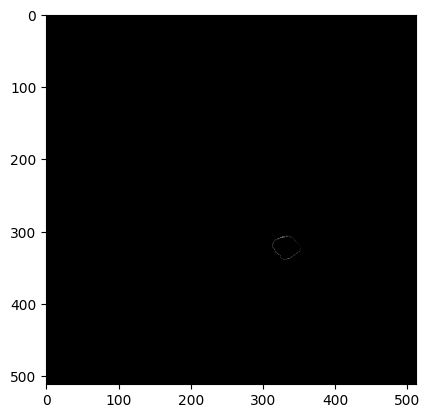

In [41]:
volume_roi1 = volumes_roi['ROI_6']

max_slice = np.argmax([volume_roi1[:, :, i].max() for i in range(volume_roi1.shape[2])])
print(f"La slice avec la valeur maximale est la slice {max_slice}.")

plt.imshow(volume_roi1[:, :, max_slice], cmap='gray')


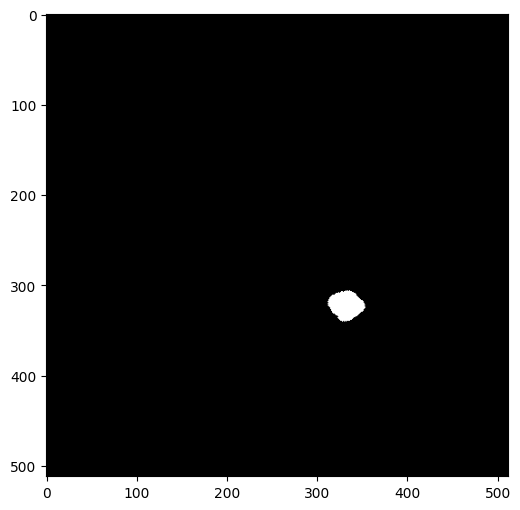

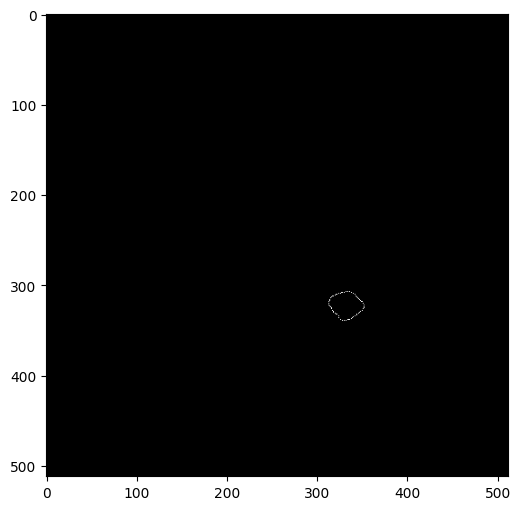

In [54]:
one_slice_of_roi = volume_roi1[:, :, max_slice]

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import binary_dilation

import numpy as np
import cv2
import matplotlib.pyplot as plt

from scipy.ndimage import binary_dilation, binary_fill_holes

def dilater_et_remplir_contours(array_2d, dilation_iterations=1):
    """
    Dilate légèrement les contours puis remplit les régions à l'intérieur des contours.
    
    Args:
        array_2d (np.array): Tableau 2D contenant les contours avec des valeurs d'intensité.
        dilation_iterations (int): Nombre d'itérations de dilatation à appliquer.
        
    Returns:
        np.array: Tableau 2D avec les régions à l'intérieur des contours remplies.
    """
    # Étape 1 : Créer un masque binaire des contours
    mask_binaire = array_2d > 0
    
    # Étape 2 : Dilater légèrement les contours
    mask_dilate = binary_dilation(mask_binaire, iterations=dilation_iterations)
    
    # Étape 3 : Remplir les trous avec binary_fill_holes
    mask_rempli = binary_fill_holes(mask_dilate)
    
    # Étape 4 : Remplacer les valeurs à l'intérieur des contours dans l'image originale
    array_rempli = np.where(mask_rempli, array_2d.max(), array_2d)
    
    return array_rempli


slice_remplie = dilater_et_remplir_contours(one_slice_of_roi)
# Afficher le résultat : 

plt.figure(figsize=(6, 6))
plt.imshow(slice_remplie, cmap='gray')

# afficher resultat avant : 

plt.figure(figsize=(6, 6))
plt.imshow(one_slice_of_roi, cmap='gray')


# tentative plus précise

In [151]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from scipy.stats import kurtosis, skew
from skimage.draw import line

def load_dicom_files(directory):
    dicom_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.dcm'):
                filepath = os.path.join(root, file)
                dicom_files.append(pydicom.dcmread(filepath))
    dicom_files.sort(key=lambda x: int(x.InstanceNumber))
    return dicom_files

def read_dicom_rtstruct(filepath):
    ds = pydicom.dcmread(filepath)
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    contours = {}
    for i, roi_contour in enumerate(ds.ROIContourSequence):
        contour_points = []
        for contour_sequence in roi_contour.ContourSequence:
            points = contour_sequence.ContourData
            num_points = len(points) // 3
            points = np.array(points).reshape(num_points, 3)
            contour_points.append(points)
        contours[f'ROI_{i+1}'] = contour_points
    
    return contours

def convert_contours_to_voxel_space(contours, dicom_files):
    pixel_spacing = dicom_files[0].PixelSpacing
    slice_thickness = dicom_files[0].SliceThickness
    image_position_patient = dicom_files[0].ImagePositionPatient

    contours_voxel_space = {}
    for roi_name, contour_list in contours.items():
        voxel_contour_list = []
        for contour in contour_list:
            voxel_contour = []
            for point in contour:
                x_mm, y_mm, z_mm = point
                x_voxel = int((x_mm - image_position_patient[0]) / pixel_spacing[0])
                y_voxel = int((y_mm - image_position_patient[1]) / pixel_spacing[1])
                z_voxel = int((z_mm - image_position_patient[2]) / slice_thickness)
                voxel_contour.append((x_voxel, y_voxel, z_voxel))
            voxel_contour_list.append(np.array(voxel_contour))
        contours_voxel_space[roi_name] = voxel_contour_list
    
    return contours_voxel_space

def remplir_contours_en_connectant_points(array_2d, contours):
    """
    Remplit les contours en connectant les points les plus proches avec des lignes droites.
    """
    mask = np.zeros_like(array_2d, dtype=np.bool_)

    # Connecter les points de contour par des lignes droites
    for i in range(len(contours) - 1):
        # prend comme entrée les coordonnées des points de départ et d’arrivée (en termes de x et y) et renvoie deux tableaux, rr et cc, qui sont les indices des lignes et des colonnes que la ligne traverse dans la grille de pixels.
        rr, cc = line(contours[i][1], contours[i][0], contours[i+1][1], contours[i+1][0])
        mask[rr, cc] = True # on def les pixels de cette ligne en tant que du masque (True)

    # Fermer le contour en reliant le dernier point au premier par sécurité
    rr, cc = line(contours[-1][1], contours[-1][0], contours[0][1], contours[0][0])
    mask[rr, cc] = True

    # Remplir les trous à l'intérieur des contours avec scipy.ndimage :
    mask_rempli = binary_fill_holes(mask)
    return mask_rempli

def appliquer_masque_sur_irm(dicom_files, contours_voxel_space):
    """
    Extrait uniquement les parties de l’image qui se trouvent à l’intérieur des contours pour chaque ROI.
    """
    volumes_roi = {}
    image_shape = dicom_files[0].pixel_array.shape
    num_slices = len(dicom_files)
    
    for roi_name, voxel_contours in contours_voxel_space.items():
        print(f"Traitement du ROI : {roi_name}")
        volume_irm_roi = np.zeros((image_shape[0], image_shape[1], num_slices), dtype=np.float32)
        
        for z, dicom_data in enumerate(dicom_files):
            image = dicom_data.pixel_array.astype(np.float32)
            masque_final = np.zeros_like(image, dtype=np.bool_)
            
            for contour in voxel_contours:
                # On extrait les points du contour qui se trouvent sur la slice actuelle (z)
                slice_contour = contour[contour[:, 2] == z] 
                # si y a des points de contours sur cette slice :
                if len(slice_contour) > 0:
                    # alors je créer un masque binaire où les régions à l’intérieur des contours sont remplies
                    mask_rempli = remplir_contours_en_connectant_points(image, slice_contour[:, :2].astype(int))
                    # On combine (opération logique OR) le masque actuel avec les masques remplis pour cette slice, afin d’obtenir le masque final pour l’ensemble des contours du ROI sur cette coupe.
                    masque_final = masque_final | mask_rempli
            
            # Appliquer le masque sur l'image IRM pour la slice courante
            image_filtre = np.where(masque_final, image, 0)
            volume_irm_roi[:, :, z] = image_filtre
        
        # Stocker le volume IRM filtré dans le dictionnaire
        volumes_roi[roi_name] = volume_irm_roi
    
    return volumes_roi

def calculer_statistiques_intensite(volumes_roi):
    for roi_name, volume in volumes_roi.items():
        # Extraire les valeurs non nulles
        non_zero_values = volume[volume > 0]
        
        # Calculer les statistiques d'intensité
        min_intensity = np.min(non_zero_values)
        max_intensity = np.max(non_zero_values)
        mean_intensity = np.mean(non_zero_values)
        std_intensity = np.std(non_zero_values)
        kurtosis_value = kurtosis(non_zero_values)
        skewness_value = skew(non_zero_values)
        
        # Affichage des statistiques
        print(f"{roi_name} :")
        print(f"  Intensité minimale : {min_intensity}")
        print(f"  Intensité maximale : {max_intensity}")
        print(f"  Intensité moyenne : {mean_intensity}")
        print(f"  Écart type : {std_intensity}")
        print(f"  Kurtosis : {kurtosis_value}")
        print(f"  Skewness : {skewness_value}")
        print()

# Chemin vers le dossier contenant les fichiers DICOM
directory_path = './IRM'
dicom_files = load_dicom_files(directory_path)

# Chemin vers le fichier RTStruct
rtstruct_path = 'rtstruct.dcm'
contours = read_dicom_rtstruct(rtstruct_path)

# Convertir les contours en coordonnées voxel
contours_voxel_space = convert_contours_to_voxel_space(contours, dicom_files)

# Appliquer le masque et récupérer les images filtrées pour chaque ROI
volumes_roi = appliquer_masque_sur_irm(dicom_files, contours_voxel_space)

# Calculer les statistiques d'intensité pour chaque ROI
calculer_statistiques_intensite(volumes_roi)

Traitement du ROI : ROI_1
Traitement du ROI : ROI_2
Traitement du ROI : ROI_3
Traitement du ROI : ROI_4
Traitement du ROI : ROI_5
Traitement du ROI : ROI_6
ROI_1 :
  Intensité minimale : 220.0
  Intensité maximale : 557.0
  Intensité moyenne : 398.2946472167969
  Écart type : 71.97498321533203
  Kurtosis : -0.9619741283624426
  Skewness : -0.06420768455535847

ROI_2 :
  Intensité minimale : 117.0
  Intensité maximale : 417.0
  Intensité moyenne : 261.1628723144531
  Écart type : 77.80584716796875
  Kurtosis : -1.1160135067465728
  Skewness : 0.01723227429361201

ROI_3 :
  Intensité minimale : 178.0
  Intensité maximale : 552.0
  Intensité moyenne : 388.19696044921875
  Écart type : 62.70731735229492
  Kurtosis : 0.07009740827353328
  Skewness : -0.3479159596166434

ROI_4 :
  Intensité minimale : 157.0
  Intensité maximale : 566.0
  Intensité moyenne : 387.82183837890625
  Écart type : 77.76763916015625
  Kurtosis : -0.4263429554785829
  Skewness : -0.12066637980397447

ROI_5 :
  Intens